# Image Classification Model Deployment : Klasifikasi Aluminium, Kaca, Kertas, Plastik

## Import Libraries

In [1]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import zipfile,os
import pathlib
import numpy as np
import splitfolders
import tensorflow as tf
from tensorflow import keras
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Prepare Dataset

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Extract file zip
local_zip = '/content/gdrive/MyDrive/Dataset/Dataset Sampah.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Exploratory Data Analysis

In [5]:
base_dir = '/content/Dataset Sampah'
os.listdir(base_dir)

['Plastik', 'Aluminium', 'Kaca', 'Kertas']

In [6]:
aluminium_dir = os.path.join(base_dir, 'Aluminium')
kaca_dir = os.path.join(base_dir, 'Kaca')
kertas_dir = os.path.join(base_dir, 'Kertas')
plastik_dir = os.path.join(base_dir, 'Plastik')

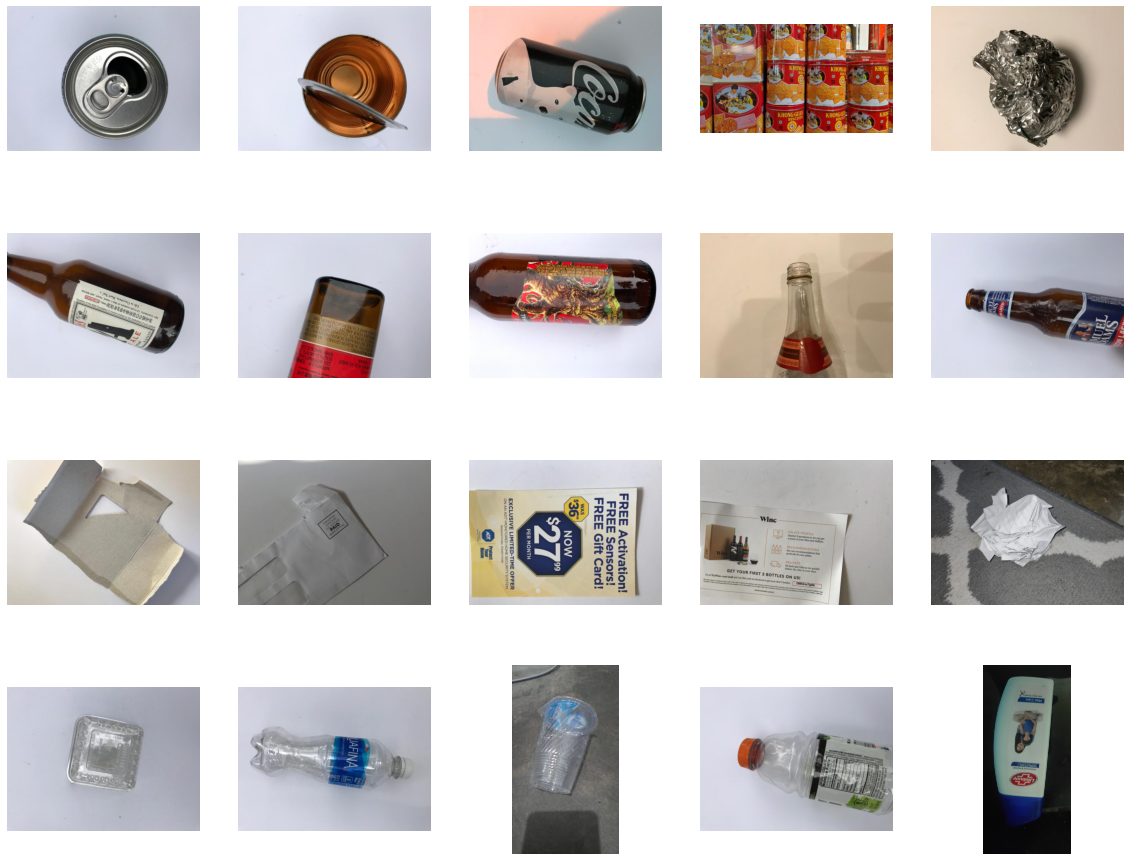

In [7]:
%matplotlib inline
files_aluminium = os.listdir(aluminium_dir)
files_kaca = os.listdir(kaca_dir)
files_kertas = os.listdir(kertas_dir)
files_plastik = os.listdir(plastik_dir)

nrows = 4
ncols = 5

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 5

images_aluminium = [os.path.join(aluminium_dir, fname)
                         for fname in files_aluminium[pic_index - 5:pic_index]]
images_kaca = [os.path.join(kaca_dir, fname)
                         for fname in files_kaca[pic_index - 5:pic_index]]
images_kertas = [os.path.join(kertas_dir, fname)
                         for fname in files_kertas[pic_index - 5:pic_index]]
images_plastik = [os.path.join(plastik_dir, fname)
                         for fname in files_plastik[pic_index - 5:pic_index]]

for i, img_path in enumerate(images_aluminium + images_kaca + images_kertas + images_plastik):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

## Train Test Split

In [8]:
splitfolders.ratio(base_dir, output = base_dir, seed = 11, ratio = (.8, .2))

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 2673 files [00:01, 2504.47 files/s]


In [9]:
train_aluminium_dir, validation_aluminium_dir = train_test_split(os.listdir(aluminium_dir), test_size = 0.2, train_size = 0.8)
train_kaca_dir, validation_kaca_dir = train_test_split(os.listdir(kaca_dir), test_size = 0.2, train_size = 0.8)
train_kertas_dir, validation_kertas_dir = train_test_split(os.listdir(kertas_dir), test_size = 0.2, train_size = 0.8)
train_plastik_dir, validation_plastik_dir = train_test_split(os.listdir(plastik_dir), test_size = 0.2, train_size = 0.8)

In [10]:
train_aluminium_dir = os.path.join(train_dir, 'Aluminium')
train_kaca_dir = os.path.join(train_dir, 'Kaca')
train_kertas_dir = os.path.join(train_dir, 'Kertas')
train_plastik_dir = os.path.join(train_dir, 'Plastik')

validation_aluminium = os.path.join(validation_dir, 'Aluminium')
validation_kaca = os.path.join(validation_dir, 'Kaca')
validation_kertas = os.path.join(validation_dir, 'Kertas')
validation_plastik = os.path.join(validation_dir, 'Plastik') 

## Data Augmentation

In [11]:
train_dir = base_dir + "/train"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    fill_mode='nearest')

validation_dir = base_dir + "/val"
validation_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
  directory=train_dir,   
  target_size=(150,150), 
  class_mode='categorical',  
  shuffle=True,
  batch_size=64)

validation_generator = validation_datagen.flow_from_directory(
  directory=validation_dir,  
  target_size=(150,150),  
  class_mode='categorical',
  shuffle=True,
  batch_size=64)

Found 2136 images belonging to 4 classes.
Found 537 images belonging to 4 classes.


## Build Architecture

In [13]:
model = tf.keras.models.Sequential([                             
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

## Implementation Callbacks

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

## Loss, Optimizer and Metrics

In [15]:
model.compile(loss ='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

## Train Model

In [16]:
history=model.fit(
    train_generator,
    epochs=15,
    batch_size=64,
    verbose=2,
    callbacks = [reduce_lr, early_stop],
    validation_data=validation_generator
)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


34/34 - 50s - loss: 1.4042 - accuracy: 0.3375 - val_loss: 1.3526 - val_accuracy: 0.3445 - lr: 0.0010 - 50s/epoch - 1s/step
Epoch 2/15
34/34 - 33s - loss: 1.3545 - accuracy: 0.3436 - val_loss: 1.3416 - val_accuracy: 0.3445 - lr: 0.0010 - 33s/epoch - 972ms/step
Epoch 3/15
34/34 - 31s - loss: 1.3508 - accuracy: 0.3446 - val_loss: 1.3393 - val_accuracy: 0.3445 - lr: 0.0010 - 31s/epoch - 924ms/step
Epoch 4/15
34/34 - 31s - loss: 1.3320 - accuracy: 0.3446 - val_loss: 1.2990 - val_accuracy: 0.3445 - lr: 0.0010 - 31s/epoch - 920ms/step
Epoch 5/15
34/34 - 37s - loss: 1.3136 - accuracy: 0.3478 - val_loss: 1.2834 - val_accuracy: 0.3445 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 6/15
34/34 - 31s - loss: 1.3009 - accuracy: 0.3689 - val_loss: 1.2568 - val_accuracy: 0.4134 - lr: 0.0010 - 31s/epoch - 926ms/step
Epoch 7/15
34/34 - 32s - loss: 1.2634 - accuracy: 0.3970 - val_loss: 1.2542 - val_accuracy: 0.3780 - lr: 0.0010 - 32s/epoch - 927ms/step
Epoch 8/15
34/34 - 36s - loss: 1.2625 - accuracy: 0.3745 -

## Plot Accuracy and Loss to Evaluation

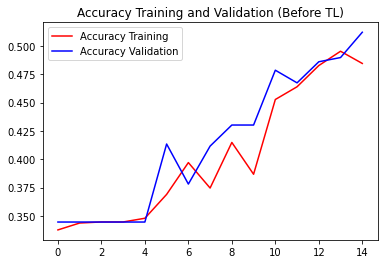

<Figure size 432x288 with 0 Axes>

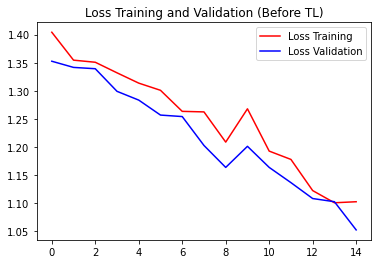

<Figure size 432x288 with 0 Axes>

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Accuracy Training')
plt.plot(epochs, val_accuracy, 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation (Before TL)')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validation')
plt.title('Loss Training and Validation (Before TL)')
plt.legend(loc=0)
plt.figure()
plt.show()

## Implementation Transfer Learning (TL)

In [18]:
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.layers[0].trainable = False

model.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               26214912  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                     

## Loss, Optimizer and Metrics

In [19]:
model.compile(loss ='categorical_crossentropy',
              optimizer = tf.optimizers.Adam(),
              metrics=['accuracy'])

## Train Model

In [20]:
history=model.fit(
    train_generator,
    epochs=15,
    batch_size=64,
    verbose=2,
    callbacks = [reduce_lr, early_stop],
    validation_data=validation_generator)

Epoch 1/15
34/34 - 44s - loss: 2.0813 - accuracy: 0.6175 - val_loss: 0.5650 - val_accuracy: 0.8026 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 2/15
34/34 - 29s - loss: 0.5580 - accuracy: 0.7982 - val_loss: 0.8162 - val_accuracy: 0.7449 - lr: 0.0010 - 29s/epoch - 849ms/step
Epoch 3/15
34/34 - 29s - loss: 0.5037 - accuracy: 0.8188 - val_loss: 0.5227 - val_accuracy: 0.8343 - lr: 0.0010 - 29s/epoch - 854ms/step
Epoch 4/15
34/34 - 30s - loss: 0.3978 - accuracy: 0.8539 - val_loss: 0.5938 - val_accuracy: 0.7896 - lr: 0.0010 - 30s/epoch - 894ms/step
Epoch 5/15
34/34 - 30s - loss: 0.3505 - accuracy: 0.8703 - val_loss: 0.5039 - val_accuracy: 0.8287 - lr: 0.0010 - 30s/epoch - 878ms/step
Epoch 6/15
34/34 - 28s - loss: 0.2935 - accuracy: 0.8872 - val_loss: 0.6239 - val_accuracy: 0.8250 - lr: 0.0010 - 28s/epoch - 838ms/step
Epoch 7/15
34/34 - 31s - loss: 0.2603 - accuracy: 0.9007 - val_loss: 0.5191 - val_accuracy: 0.8585 - lr: 0.0010 - 31s/epoch - 907ms/step
Epoch 8/15
34/34 - 29s - loss: 0.2796 - accu

## Plot Accuracy and Loss to Evaluation

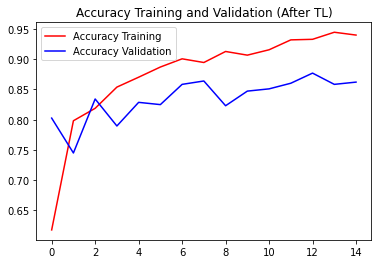

<Figure size 432x288 with 0 Axes>

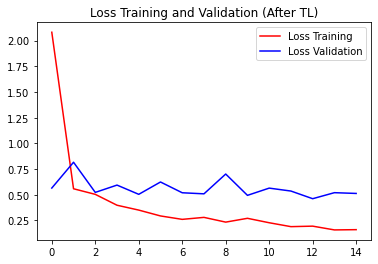

<Figure size 432x288 with 0 Axes>

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Accuracy Training')
plt.plot(epochs, val_accuracy, 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation (After TL)')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validation')
plt.title('Loss Training and Validation (After TL)')
plt.legend(loc=0)
plt.figure()
plt.show()

## Predict Image

### 1. Create Predict Function

In [22]:
def predict_image(image_upload, model = model):
  imge = image_upload
  imge_array = np.asarray(imge)
  imge_array = imge_array*(1/225)
  imge_input = tf.reshape(imge_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(imge_input)[0]
  predict_kelas = np.argmax(model.predict(imge_input))

  if predict_kelas == 0:
      predict_item = 'Aluminium'
  elif predict_kelas == 1:
      predict_item = 'Kaca'
  elif predict_kelas == 2:
      predict_item = 'Kertas'
  elif predict_kelas == 3:
      predict_item = 'Plastik'
  else:
      predict_item = 'Bukan Kaca, Plastik, Kertas dan Aluminium'

  return predict_item

In [23]:
def predict():
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = fn
    img = tf.keras.utils.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = np.vstack([x])

  kelas = predict_image(img)

  print('\n')
  plt.show()
  print('The model detected images as ' + kelas)

### 2. Try Predict

Saving 1.jpg to 1.jpg
1/1 [==============================] - 0s 29ms/step




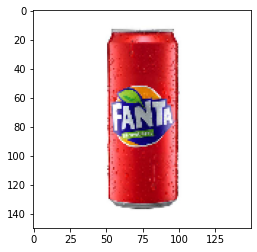

The model detected images as Aluminium


In [24]:
predict()

Saving 2.jpg to 2.jpg
1/1 [==============================] - 0s 28ms/step




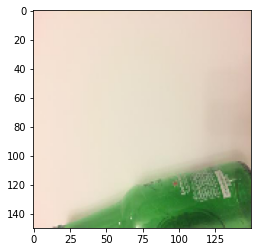

The model detected images as Kaca


In [25]:
predict()

Saving 3.jpg to 3.jpg
1/1 [==============================] - 0s 29ms/step




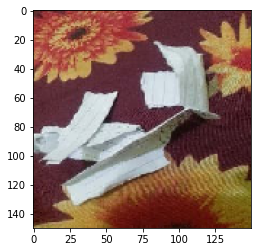

The model detected images as Kertas


In [26]:
predict()

Saving 4.jpg to 4.jpg
1/1 [==============================] - 0s 28ms/step




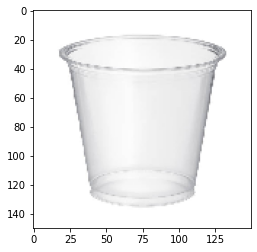

The model detected images as Plastik


In [27]:
predict()

## Save Model

In [28]:
model.save("model.hdf5")